In [1]:
conda install -c conda-forge gdcm


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.9.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gdcm-2.8.9                 |   py37h500ead1_1         3.4 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.4 MB

The following packages will be UPDATED:

  gdcm                                 2.8.9-py37h71b2a6d_0 --> 2.8.9-py37h500ead1_1



gdcm-2.8.9           | 3.4 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packag

In [2]:
from __future__ import print_function
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import glob
import urllib.request
import os.path
import tempfile
import datetime
import urllib.request
import SimpleITK as sitk
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

 
from scipy.spatial import distance as dist
from skimage import exposure

# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage

%matplotlib inline



In [3]:
import pylab

#https://medium.com/@hengloose/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed



def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def get_hu(ds):
    hu = ds.pixel_value * slope + intercept
    return hu


def crop_center(img,cropx,cropy):
    #https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
    y,x = img.shape
 
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)  
    return img[starty:starty+cropy,startx:startx+cropx]

def crop_sup_left(img,cropx,cropy):
    y,x = img.shape
    startx = x//3-(cropx//2)
    starty = y//3-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

def crop_inf_left(img,cropx,cropy):
    y,x = img.shape
    startx = (x//2)//3-(cropx//2)
    starty = (y//3)-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


def crop_sup_rig(img,cropx,cropy):
    y,x = img.shape
    startx = (x//3)-(cropx//2)
    starty = (y//2)//3-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def crop_sup_rig(img,cropx,cropy):
    y,x = img.shape
    startx = (x//2)//3-(cropx//2)
    starty = (y//2)//3-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


def detect_edge(img):
    # Lendo Imagem
    binary_image = np.array(img >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
#https://medium.com/@hengloose/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed
'''
var canvas = document.getElementById('exampleCanvas'),
    context = canvas.getContext('2d');


x =512
y=512
context.fillStyle = 'yellow';
context.fillRect(x/2, y/2, 20, 20);

//sup_left
context.fillStyle = 'black';
context.fillRect((x)/1.5, y/1.5, 20, 20);

//inf_left
context.fillStyle = 'green';
context.fillRect((x/2)/1.5, y/1.5, 20, 20);


//sup_rig
context.fillStyle = 'blue';
context.fillRect((x/1.5), (y/2)/1.5, 20, 20);

//sup_left
context.fillStyle = 'cyan';
context.fillRect((x/2)/1.5, (y/2)/1.5, 20, 20);

'''

"\nvar canvas = document.getElementById('exampleCanvas'),\n    context = canvas.getContext('2d');\n\n\nx =512\ny=512\ncontext.fillStyle = 'yellow';\ncontext.fillRect(x/2, y/2, 20, 20);\n\n//sup_left\ncontext.fillStyle = 'black';\ncontext.fillRect((x)/1.5, y/1.5, 20, 20);\n\n//inf_left\ncontext.fillStyle = 'green';\ncontext.fillRect((x/2)/1.5, y/1.5, 20, 20);\n\n\n//sup_rig\ncontext.fillStyle = 'blue';\ncontext.fillRect((x/1.5), (y/2)/1.5, 20, 20);\n\n//sup_left\ncontext.fillStyle = 'cyan';\ncontext.fillRect((x/2)/1.5, (y/2)/1.5, 20, 20);\n\n"

file count: 40


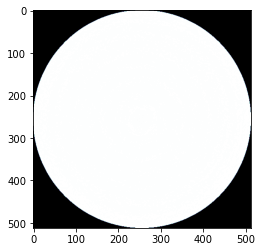

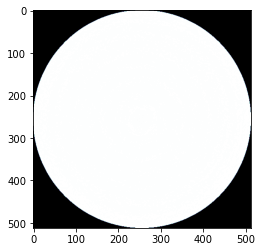

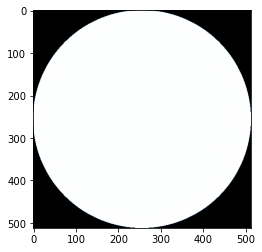

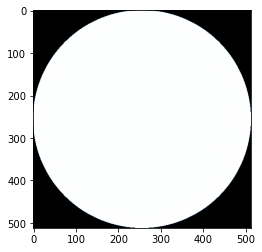

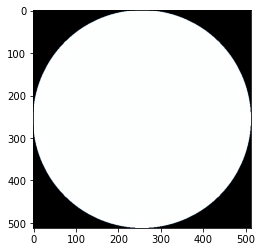

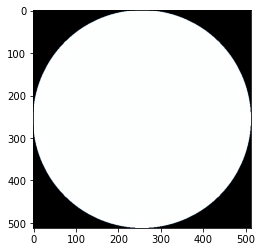

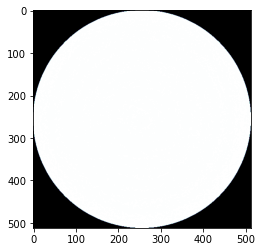

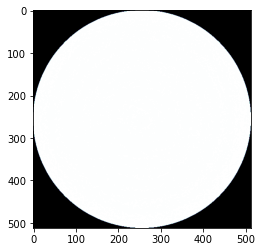

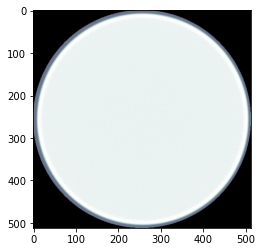

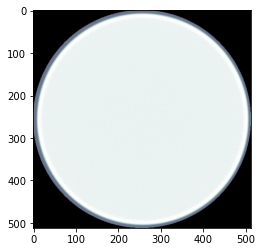

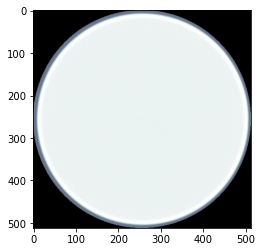

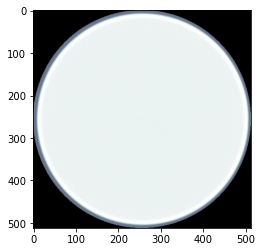

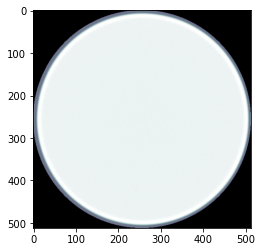

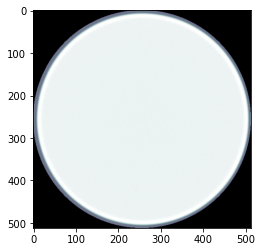

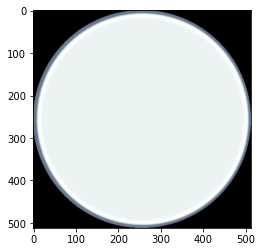

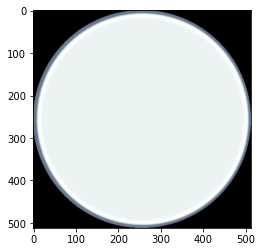

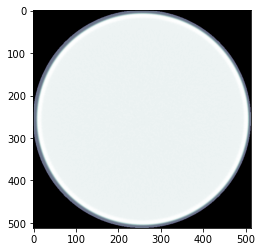

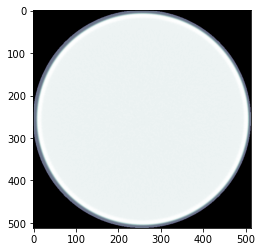

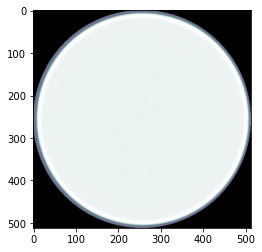

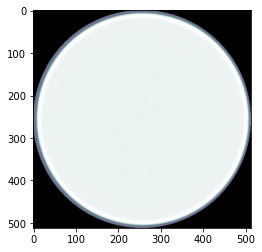

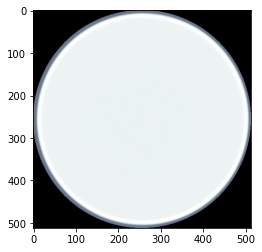

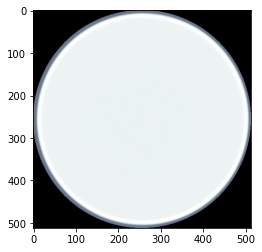

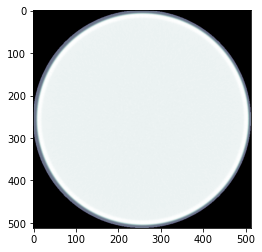

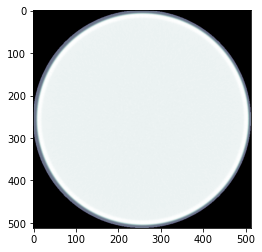

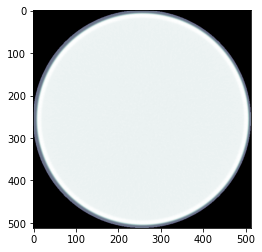

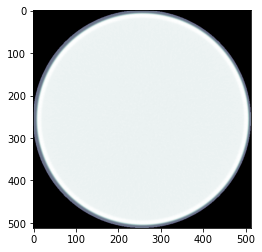

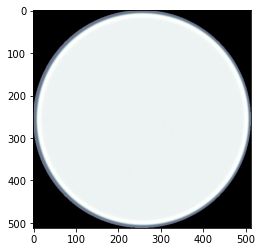

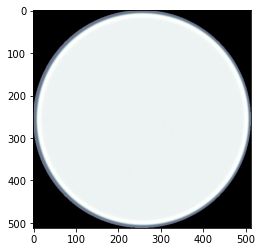

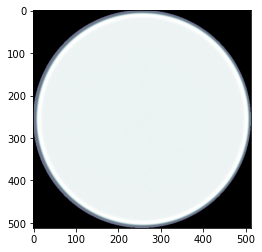

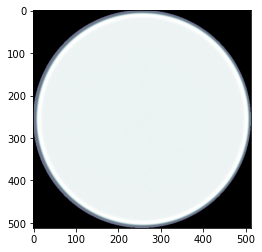

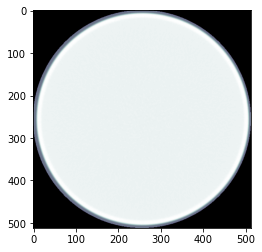

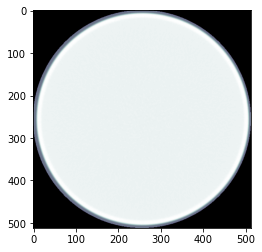

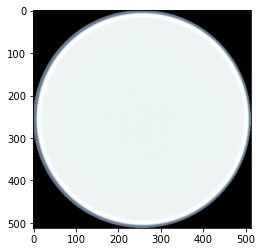

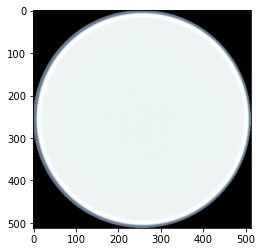

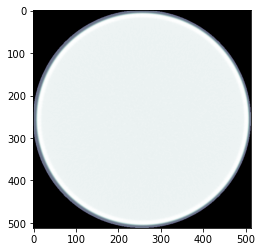

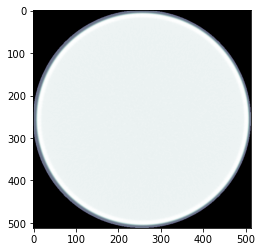

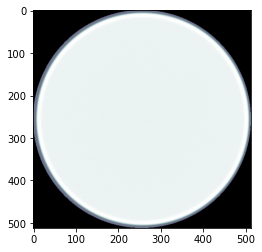

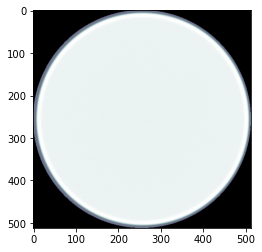

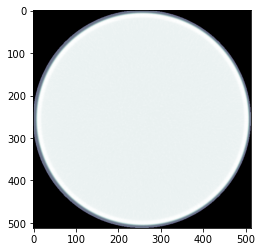

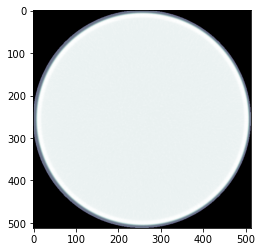

In [4]:
folder_input_dcm = 'dcm/ct/head'
reader = sitk.ImageSeriesReader()
dicom_names = list(reader.GetGDCMSeriesFileNames(folder_input_dcm))


# load the DICOM files
files = []
for fname in dicom_names:
    ## TEM QUE CHECAR SE È CT..... ou se tem slice location...
    #print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))


print("file count: {}".format(len(files)))
for ds in files:
    '''

    lx, ly = ds.pixel_array.shape
    X, Y = np.ogrid[0:lx, 0:ly]
    mask = (X - lx/2)**2 + (Y - ly/2)**2 < lx*ly/8  # defining mask, < instead of >
    #print(np.std(ds.pixel_array[mask])) # trying to get standard deviation
 
    detect_edge(ds.pixel_array)
    roi = 100
    print("Desvio Padrão")
    print(np.std((crop_center(ds.pixel_array,roi,roi))))
    
    print("Média do Número de Pixels")
    print(np.mean((crop_center(ds.pixel_array,roi,roi))))
    
    print("Hounsfield")
    print(np.mean((crop_center(ds.pixel_array,roi,roi))))   
    
    plt.imshow(crop_sup_rig(ds.pixel_array,roi,roi), cmap=pylab.cm.bone) # shows image with mask
  
    plt.imshow(crop_sup_left(ds.pixel_array,roi,roi), cmap=pylab.cm.bone) # shows image with mask
    plt.show()      
        '''
    plt.imshow(ds.pixel_array, cmap=pylab.cm.bone) # shows image with mask
    plt.show()    
